Image GPT [https://openai.com/blog/image-gpt/](https://openai.com/blog/image-gpt/)

Barebones demo, this just samples 32x32 images. That site shows lovely 64x64 images but the XL sized model isn't available. (Yet?)

(Runtime)->(Run All) will work unless you get really unlucky with the GPU.

Notebook by [https://twitter.com/jonathanfly](https://twitter.com/jonathanfly) 

In [ ]:
!nvidia-smi #OpenAI says you need 16GB GPU for the large model, but it may work if you lower n_sub_batch on the others.

In [5]:
model_sizes = ["s", "m", "l"] #small medium large, xl not available
model_sizes = ["l"] #actually just download one

In [ ]:
!rm /content/image-gpt/output/

In [57]:
n_sub_batch = 8 #8 is default, trying lowering if this doesn't work.
n_sub_batch = 8

In [ ]:
!git clone https://github.com/openai/image-gpt.git
!pip install tensorflow-gpu==1.13.1
%cd /content/image-gpt

!mkdir /content/image-gpt/models
!mkdir /content/image-gpt/clusters
!mkdir /content/image-gpt/datasets

for model_size in model_sizes:
    !mkdir ./models/{model_size}
    !python download.py --model {model_size} --ckpt 1000000 --download_dir ./models/{model_size} #models
    #!python download.py --dataset imagenet --download_dir ./datasets/{model_size} #dataset
    !python download.py --clusters --download_dir ./clusters/{model_size} #color clusters

In [9]:
#@title Update run.py to skip checking for the dataset

%%writefile /content/image-gpt/src/run.py
import argparse
import json
import math
import os
import random
import sys
import time

import numpy as np
import tensorflow as tf

from imageio import imwrite
from scipy.special import softmax
from tensorflow.contrib.training import HParams
from tqdm import tqdm

from model import model
from utils import iter_data, count_parameters


def parse_arguments():
    parser = argparse.ArgumentParser()

    # data and I/O
    parser.add_argument("--data_path", type=str, default="/root/downloads/imagenet")
    parser.add_argument("--ckpt_path", type=str, default="/root/downloads/model.ckpt-1000000")
    parser.add_argument("--color_cluster_path", type=str, default="/root/downloads/kmeans_centers.npy")
    parser.add_argument("--save_dir", type=str, default="/root/save/")

    # model
    parser.add_argument("--n_embd", type=int, default=512)
    parser.add_argument("--n_head", type=int, default=8)
    parser.add_argument("--n_layer", type=int, default=24)
    parser.add_argument("--n_px", type=int, default=32, help="image height or width in pixels")
    parser.add_argument("--n_vocab", type=int, default=512, help="possible values for each pixel")

    parser.add_argument("--bert", action="store_true", help="use the bert objective (defaut: autoregressive)")
    parser.add_argument("--bert_mask_prob", type=float, default=0.15)
    parser.add_argument("--clf", action="store_true", help="add a learnable classification head")

    # parallelism
    parser.add_argument("--n_sub_batch", type=int, default=8, help="per-gpu batch size")
    parser.add_argument("--n_gpu", type=int, default=8, help="number of gpus to distribute training across")

    # mode
    parser.add_argument("--eval", action="store_true", help="evaluates the model, requires a checkpoint and dataset")
    parser.add_argument("--sample", action="store_true", help="samples from the model, requires a checkpoint and clusters")

    # reproducibility
    parser.add_argument("--seed", type=int, default=42, help="seed for random, np, tf")

    args = parser.parse_args()
    print("input args:\n", json.dumps(vars(args), indent=4, separators=(",", ":")))
    return args


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)


def load_data(data_path):
    trX = np.load(f'{data_path}_trX.npy')
    trY = np.load(f'{data_path}_trY.npy')
    vaX = np.load(f'{data_path}_vaX.npy')
    vaY = np.load(f'{data_path}_vaY.npy')
    teX = np.load(f'{data_path}_teX.npy')
    teY = np.load(f'{data_path}_teY.npy')
    return (trX, trY), (vaX, vaY), (teX, teY)


def set_hparams(args):
    return HParams(
        n_ctx=args.n_px*args.n_px,
        n_embd=args.n_embd,
        n_head=args.n_head,
        n_layer=args.n_layer,
        n_vocab=args.n_vocab,
        bert=args.bert,
        bert_mask_prob=args.bert_mask_prob,
        clf=args.clf,
    )


def create_model(x, y, n_gpu, hparams):
    gen_logits = []
    gen_loss = []
    clf_loss = []
    tot_loss = []
    accuracy = []

    trainable_params = None
    for i in range(n_gpu):
        with tf.device("/gpu:%d" % i):
            results = model(hparams, x[i], y[i], reuse=(i != 0))

            gen_logits.append(results["gen_logits"])
            gen_loss.append(results["gen_loss"])
            clf_loss.append(results["clf_loss"])

            if hparams.clf:
                tot_loss.append(results["gen_loss"] + results["clf_loss"])
            else:
                tot_loss.append(results["gen_loss"])

            accuracy.append(results["accuracy"])

            if i == 0:
                trainable_params = tf.trainable_variables()
                print("trainable parameters:", count_parameters())

    return trainable_params, gen_logits, gen_loss, clf_loss, tot_loss, accuracy


def reduce_mean(gen_loss, clf_loss, tot_loss, accuracy, n_gpu):
    with tf.device("/gpu:0"):
        for i in range(1, n_gpu):
            gen_loss[0] += gen_loss[i]
            clf_loss[0] += clf_loss[i]
            tot_loss[0] += tot_loss[i]
            accuracy[0] += accuracy[i]
        gen_loss[0] /= n_gpu
        clf_loss[0] /= n_gpu
        tot_loss[0] /= n_gpu
        accuracy[0] /= n_gpu


def evaluate(sess, evX, evY, X, Y, gen_loss, clf_loss, accuracy, n_batch, desc, permute=False):
    metrics = []
    for xmb, ymb in iter_data(evX, evY, n_batch=n_batch, truncate=True, verbose=True):
        metrics.append(sess.run([gen_loss[0], clf_loss[0], accuracy[0]], {X: xmb, Y: ymb}))
    eval_gen_loss, eval_clf_loss, eval_accuracy = [np.mean(m) for m in zip(*metrics)]
    print(f"{desc} gen: {eval_gen_loss:.4f} clf: {eval_clf_loss:.4f} acc: {eval_accuracy:.2f}")


# naive sampler without caching
def sample(sess, X, gen_logits, n_sub_batch, n_gpu, n_px, n_vocab, clusters, save_dir):
    samples = np.zeros([n_gpu * n_sub_batch, n_px * n_px], dtype=np.int32)

    for i in tqdm(range(n_px * n_px), ncols=80, leave=False):
        np_gen_logits = sess.run(gen_logits, {X: samples})
        for j in range(n_gpu):
            p = softmax(np_gen_logits[j][:, i, :], axis=-1)  # logits to probas
            for k in range(n_sub_batch):
                c = np.random.choice(n_vocab, p=p[k])  # choose based on probas
                samples[j * n_sub_batch + k, i] = c
    
    # dequantize
    samples = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [32, 32, 3]).astype(np.uint8) for s in samples]

    # write to png
    for i in range(n_gpu * n_sub_batch):
        imwrite(f"{args.save_dir}/seed_{args.seed}_sample_{i}.png", samples[i])


def main(args):
    set_seed(args.seed)

    n_batch = args.n_sub_batch * args.n_gpu

    if args.sample:
        n_class = 1000
        print("Skipping dataset requirement for sampling.")
    else:
        if args.data_path.endswith("cifar10"):
            n_class = 10
        elif args.data_path.endswith("imagenet"):
            n_class = 1000
        else:
            raise ValueError("Dataset not supported.")

    X = tf.placeholder(tf.int32, [n_batch, args.n_px * args.n_px])
    Y = tf.placeholder(tf.float32, [n_batch, n_class])

    x = tf.split(X, args.n_gpu, 0)
    y = tf.split(Y, args.n_gpu, 0)

    hparams = set_hparams(args)
    trainable_params, gen_logits, gen_loss, clf_loss, tot_loss, accuracy = create_model(x, y, args.n_gpu, hparams)
    reduce_mean(gen_loss, clf_loss, tot_loss, accuracy, args.n_gpu)

    saver = tf.train.Saver(var_list=[tp for tp in trainable_params if not 'clf' in tp.name])
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)) as sess:
        sess.run(tf.global_variables_initializer())

        saver.restore(sess, args.ckpt_path)

        if args.eval:
            (trX, trY), (vaX, vaY), (teX, teY) = load_data(args.data_path)
            evaluate(sess, trX[:len(vaX)], trY[:len(vaY)], X, Y, gen_loss, clf_loss, accuracy, n_batch, "train")
            evaluate(sess, vaX, vaY, X, Y, gen_loss, clf_loss, accuracy, n_batch, "valid")
            evaluate(sess, teX, teY, X, Y, gen_loss, clf_loss, accuracy, n_batch, "test")

        if args.sample:
            if not os.path.exists(args.save_dir):
                os.makedirs(args.save_dir)
            clusters = np.load(args.color_cluster_path)
            sample(sess, X, gen_logits, args.n_sub_batch, args.n_gpu, args.n_px, args.n_vocab, clusters, args.save_dir)


if __name__ == "__main__":
    args = parse_arguments()
    main(args)


Overwriting /content/image-gpt/src/run.py


In [ ]:
#large model
#Generates 8 images in /content/image-gpt/output 
#change seed from 42 to geneate different samples
!python src/run.py --sample --n_embd 1536 --n_head 16 --n_layer 48 \
--ckpt_path /content/image-gpt/models/l/model.ckpt-1000000 --color_cluster_path /content/image-gpt/clusters/l/kmeans_centers.npy \
--data_path /content/image-gpt/datasets/s/imagenet_notused --save_dir /content/image-gpt/output \
--n_gpu 1 --n_px 32 --n_sub_batch {n_sub_batch} --seed 42

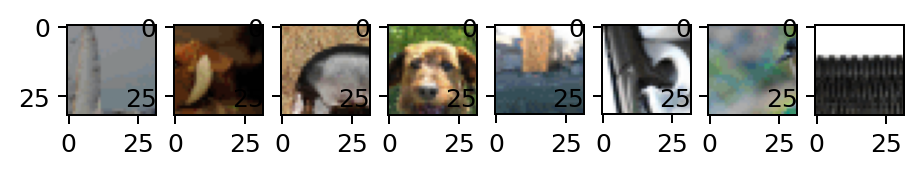

In [60]:
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

samples = pathlib.Path('/content/image-gpt/output').glob('*.png')

f, axarr = plt.subplots(1,len(glob.glob('/content/image-gpt/output/*.png')),dpi=180)

i = 0
for image in samples:
    axarr[i].imshow(mpimg.imread(image))
    i += 1

In [ ]:
#small model
#!python src/run.py --sample --n_embd 512  --n_head 8  --n_layer 24 \
#--ckpt_path /content/image-gpt/models/s/model.ckpt-1000000 --color_cluster_path /content/image-gpt/clusters/s/kmeans_centers.npy \
#--data_path /content/image-gpt/datasets/s/imagenet_notused --save_dir /content/image-gpt/output \
#--n_gpu 1